# Allen-Cahn 1D
Adapted from [FEniCS Docs](https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/periodic/python/documentation.html)
Goal: solve the Allen-Cahn PDE given as

$
\begin{align}
& u_t - \frac{u_{xx}}{10000} + 5u^3 - 5u = 0, \\
& u(x,0)=x^2cos(\pi x), \\
& u(t,-1)=u(t,1), \\
& u_x(t,-1)=u_x(t,1)
\end{align}
$

where $x \in [-1,1]\text{ and }t \in [0,1]$

In [1]:
from dolfin import *
from time import perf_counter
import scipy.io
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook

output = "solutions/allen-cahn-1d/"

In [2]:
## parameters
#####################################

nx       = 1000        # mesh points
dt       = 5.0e-3      # time step
(x0, xf) = (-1.0, 1.0) # boundaries
order    = 2           # mesh polynomial order

# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

In [3]:
# Class for interfacing with the Newton solver
class AllenCahnEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

In [4]:
# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        return near(x[0], x0) and on_boundary

    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
        y[0] = x[0] - (xf - x0)

In [5]:
# formulate problem
#####################################

# create periodic boundary condition
pbc = PeriodicBoundary()

# setup mesh
mesh = IntervalMesh(nx, x0, xf)
V = FunctionSpace(mesh, "CG", order, constrained_domain=pbc)

# define test & trial functions
du = TrialFunction(V)
v = TestFunction(V)

# define functions
u = Function(V)
u0 = Function(V)

# initial conditions
u_init = Expression("pow(x[0],2)*sin(2*pi*x[0])", degree=2)
u.interpolate(u_init)
u0.interpolate(u_init)

gamma1 = 0.0001
gamma2 = 4 # {test 1 (easiest):4 (hardest)}

F = u*v*dx - u0*v*dx +                    \
    dt*gamma1*dot(grad(u), grad(v))*dx +  \
    dt*gamma2*(u**3 - u)*v*dx

J = derivative(F, u, du)

In [6]:
# Create nonlinear problem and Newton solver
problem = AllenCahnEquation(J, F)
solver = NewtonSolver()

file = File(output + "data/ac.pvd")

In [7]:
# map mesh vertices to solution DOFs
#####################################

dof_coordinates = V.tabulate_dof_coordinates()

# extract subspace indicies
u_dofs = V.dofmap().dofs()

# get indicies of sorted result
dofs      = np.squeeze(dof_coordinates[u_dofs])
asc_order = np.argsort(dofs)

<IPython.core.display.Javascript object>


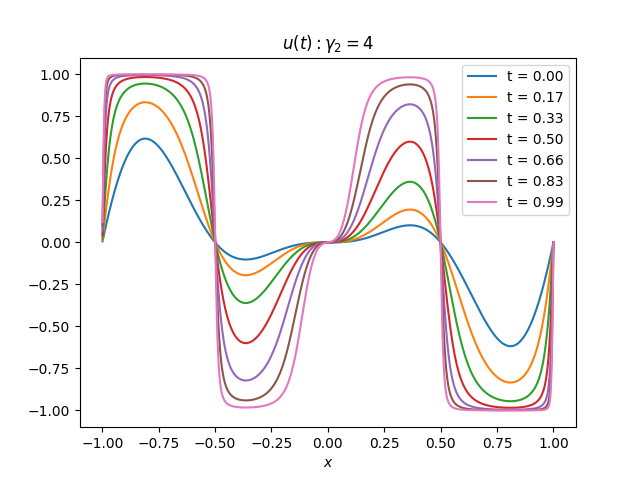

0 / 200
20 / 200
40 / 200
60 / 200
80 / 200
100 / 200
120 / 200
140 / 200
160 / 200
180 / 200

Took 3.25 seconds.


In [8]:
# time stepping
#####################################

(t, T) = (0.0, 1.0)
(n, N) = (0, int(round(T/dt, 0)))

plt.figure(1)
plt.title(f"$u(t):\gamma_2={gamma2}$")
plt.xlabel("$x$")
labels = []

sol = {}
sol['x'] = dofs[asc_order]
sol['t'] = np.zeros((N,1))
sol['u'] = np.zeros((len(sol['x']), len(sol['t'])))

t0 = perf_counter()
while n < N:
    
    # compute current solution
    solver.solve(problem, u.vector())
    
    # save output
    # file << (u.split()[0], t)
    sol['t'][n] = t
    sol['u'][:,n] = u.vector()[asc_order]
    
    # update previous solution
    u0.vector()[:] = u.vector()
    
    # plot 6 solution snapshots
    if n % round(N/6,0) == 0:
        plt.plot(dofs[asc_order], u.vector()[asc_order])
        labels.append(f"t = {t/T:.2f}")
    
    # print progress
    if n % round(N/10,0) == 0:
        print(f"{n} / {N}")
        
    # increment time
    t += dt
    n += 1
        

tf = perf_counter()
print(f"\nTook {tf-t0:.2f} seconds.")

scipy.io.savemat(output + 'AC_1D.mat', sol)

plt.legend(labels)
plt.show()
plt.savefig(output + "allen-cahn-1d.png")

In [9]:
def snapshot(i):
    plt.clf()
    plt.plot(sol['x'], sol['u'][:,i],'b-',linewidth = 3)       
    plt.rc('xtick',labelsize=12)
    plt.rc('ytick',labelsize=12)
    plt.ylim([-1.05, 1.05])
    plt.xlabel('$x$',fontsize='x-large')
    plt.ylabel(f'$u(t,x)$',fontsize='x-large')
    plt.title(f'Allen-Cahn: $\gamma_2={gamma2}$')

<IPython.core.display.Javascript object>


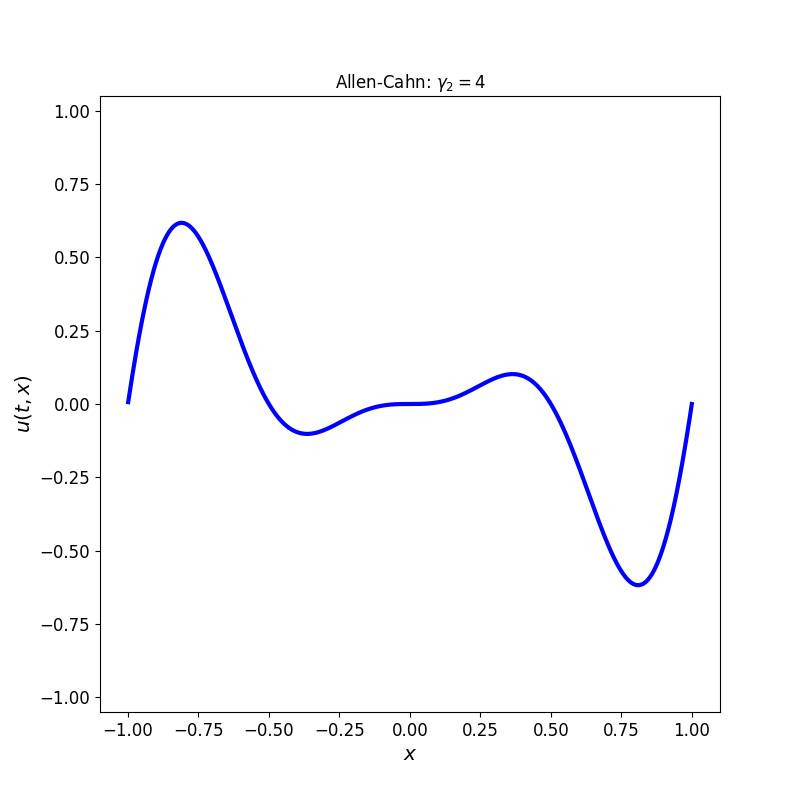

In [10]:
fig = plt.figure(figsize=(8,8), dpi=100)
anim = animation.FuncAnimation(fig,snapshot,frames=N)
anim.save(output + 'allen-cahn-1d.mp4',fps=N/10)